In [8]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import re
import requests
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Dataset

In [3]:
df = pd.read_csv(r'C:\Users\arceb\PycharmProjects\Projet_DSSS_2023\data_cleaned/initial_corpus.csv')
df

Journal  \
0      Le Figaro, no. 23520      
1                  Le Monde      
2      Le Figaro (site web)      
3       Le Monde (site web)      
4       Le Monde (site web)      
...                        ...   
8913                 Les Echos   
8914                  La Croix   
8915                 Le Figaro   
8916                 Le Figaro   
8917                 Le Figaro   

                                                  Titre        Date  \
0                    L'agenda cach√© de Moscou en Italie  2020-03-30   
1     R√©cit   Les trois semaines qui ont chamboul√© l...  2020-03-27   
2     √âlargissement de l‚ÄôUnion europ√©enne √† l‚Äôheure ...  2020-03-26   
3     Coronavirus¬†: les trois semaines qui ont chamb...  2020-03-26   
4     Marc Lazar¬†: ¬´¬†Plus l‚ÄôItalie fait nation face ...  2020-03-25   
...                                                 ...         ...   
8913  Crise  migratoire aux Canaries : l'Europe doit...  2020-05-27   
8914  Migrants en mer Eg√©e : ¬´√áa a √©t√© les deux heur...  2020-04-15   
8915  Migrants: Dakhla, point de d√©part du grand cou...  2020-04-14   
8916  Pacte migratoire?: les pays du sud sauveront-i...  2020-04-12   
8917  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   

                                                 Auteur  \
0                                    Lasserre, Isabelle   
1     √âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret...   
2                                     Tandonnet, Maxime   
3     Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet...   
4                                            Marc Lazar   
...                                                 ...   
8913                                                NaN   
8914                                                NaN   
8915                                                NaN   
8916                                                NaN   
8917                                                NaN   

                                                  Texte  \
0     LES SYMBOLES comptent parfois plus que les fai...   
1     Londres, Berlin, Rome et Bruxelles corresponda...   
2     Fin observateur de la vie politique fran√ßaise ...   
3     Jeudi 26¬†mars, les Vingt-Sept doivent se r√©uni...   
4     Tribune. L‚ÄôItalie est le pays qui enregistre √†...   
...                                                 ...   
8913  La d√©ception a √©t√© √† la hauteur de l'espoir, i...   
8914  Les faits En 2015, des ¬´?zones de transit?¬ª av...   
8915  Bruxelles esp√®re arriver √† des ¬´ r√©sultats imp...   
8916  C'EST L'UNE des rares bonnes nouvelles de l'an...   
8917  16/20    ¬´ Raised By Wolves ¬ª , dix √©pisodes d...   

                                          extrait_debut  \
0      Sur les camions militaires qui, en colonnes, ...   
1      - Jeudi 26 mars, les Vingt-Sept devaient se r...   
2     contributeur r√©gulier du FigaroVox, Maxime Tan...   
3     n visioconf√©rence pour la troisi√®me fois en mo...   
4      date du 25¬†mars le plus grand nombre de morts...   
...                                                 ...   
8913  nse, il y a dix ans. Le 17 december2010, le su...   
8914  nt √©t√© mises en place par le pays dans les vil...   
8915  ants ¬ª en 2021 sur la r√©forme de l'asile pr√©se...   
8916   2020 : la pand√©mie, gr√¢ce au plan de relance ...   
8917  0 minutes, lundi 7 decembersur warner tv, √† 20...   

                                            extrait_fin CJournal  
0     Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
1     pand√©mie touche tout le monde, indiff√©remment ...    Monde  
2     es yeux et de se pr√©parer au changement d‚Äôun m...   Figaro  
3     e la tenue de ses comptes publics, n‚Äôest pas s...    Monde  
4     t de la School of Government de la Luiss (Libr...    Monde  
...                                                 ...      ...  
8913  e n'ait √©t√© qu'une illustration de cette ligne...    Echos  
8914  programme lanc√© e

### CAMEMBERT

In [7]:
from transformers import pipeline

# Set up the inference pipeline using a model from the ü§ó Hub
sentiment_analysis = pipeline(model="Peed911/french_sentiment_analysis")

In [5]:
# Function to split text into three rows
def split_text(row):
    texts = row['Texte'].split('. ')
    return pd.Series(texts)

# Apply the function to each row and stack the resulting rows
new_df = df.apply(split_text, axis=1).stack().reset_index(level=1, drop=True).to_frame('Texte')

# Merge the other columns from the original DataFrame
new_df = new_df.join(df.drop('Texte', axis=1), how='left')

# Reset index if needed
new_df.reset_index(drop=True, inplace=True)


new_df

Texte  \
0        LES SYMBOLES comptent parfois plus que les faits   
1       Sur les camions militaires qui, en colonnes, o...   
2         C'est une aide humanitaire qui ressemble √† u...   
3       Avec la Chine, la Russie a √©t√© la premi√®re √† r...   
4       √Ä grand renfort de publicit√© et de propagande,...   
...                                                   ...   
282068  Parce que l'on se fatigue rapidement des crise...   
282069  Parce que l'on a compris que ce flic du SRP de...   
282070  La l√©giste en question se trouve √™tre aussi l'...   
282071  La suite, on vous la laisse d√©couvrir, si vous...   
282072     FRAN√áOIS AUBEL, JULIA BAUDIN, C√âLINE FONTAN...   

                         Journal  \
0        Le Figaro, no. 23520      
1        Le Figaro, no. 23520      
2        Le Figaro, no. 23520      
3        Le Figaro, no. 23520      
4        Le Figaro, no. 23520      
...                          ...   
282068                 Le Figaro   
282069                 Le Figaro   
282070                 Le Figaro   
282071                 Le Figaro   
282072                 Le Figaro   

                                                    Titre        Date  \
0                      L'agenda cach√© de Moscou en Italie  2020-03-30   
1                      L'agenda cach√© de Moscou en Italie  2020-03-30   
2                      L'agenda cach√© de Moscou en Italie  2020-03-30   
3                      L'agenda cach√© de Moscou en Italie  2020-03-30   
4                      L'agenda cach√© de Moscou en Italie  2020-03-30   
...                                                   ...         ...   
282068  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
282069  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
282070  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
282071  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
282072  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   

                    Auteur                                      extrait_debut  \
0       Lasserre, Isabelle   Sur les camions militaires qui, en colonnes, ...   
1       Lasserre, Isabelle   Sur les camions militaires qui, en colonnes, ...   
2       Lasserre, Isabelle   Sur les camions militaires qui, en colonnes, ...   
3       Lasserre, Isabelle   Sur les camions militaires qui, en colonnes, ...   
4       Lasserre, Isabelle   Sur les camions militaires qui, en colonnes, ...   
...                    ...                                                ...   
282068                 NaN  0 minutes, lundi 7 decembersur warner tv, √† 20...   
282069                 NaN  0 minutes, lundi 7 decembersur warner tv, √† 20...   
282070                 NaN  0 minutes, lundi 7 decembersur warner tv, √† 20...   
282071                 NaN  0 minutes, lundi 7 decembersur warner tv, √† 20...   
282072                 NaN  0 minutes, lundi 7 decembersur warner tv, √† 20...   

                                              extrait_fin CJournal  
0       Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
1       Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
2       Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
3       Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
4       Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
...                                                   ...      ...  
282068  r, si vous ne vous endormez pas devant cette b...   Figaro  
282069  r, si vous ne vous endormez pas devant cette b...   Figaro  
282070  r, si vous ne vous endormez pas devant cette b...   Figaro  
282071  r, si vous ne vous endormez pas devant cette b...   Figaro  
282072  r, si vous ne vous endormez pas devant cette b...   Figaro  

[282073 rows x 8 columns]

In [6]:
new_df['Texte'][15]

"En posant leur empreinte militaire sur le sol italien, les Russes pourraient aussi chercher √† se doter d'un pont vers la Libye, o√π ils soutiennent le mar√©chal dissident Haftar et tentent d'imposer une solution diplomatique √† la crise"

In [ ]:
# Creating an empty list to store the results
articles_sentiment = []

# Iterating over each row in the DataFrame
for index, row in new_df.iterrows():
    try:
        content = row['Texte']
        sentiment = sentiment_analysis(content)
        articles_sentiment.append({'article': content, 'sentiment': sentiment})
    except Exception as e:
        print(f"Error processing article at index {index}: {e}")


KeyboardInterrupt: 

In [81]:
# Creating a new DataFrame from the results
sentiment_df = pd.DataFrame(articles_sentiment)

In [82]:
sentiment_df

article  \
0        LES SYMBOLES comptent parfois plus que les faits   
1       Sur les camions militaires qui, en colonnes, o...   
2         C'est une aide humanitaire qui ressemble √† u...   
3       Avec la Chine, la Russie a √©t√© la premi√®re √† r...   
4       √Ä grand renfort de publicit√© et de propagande,...   
...                                                   ...   
115675  Ne croyons pas que cette "crisemigratoire" est...   
115676  Elle est mondiale et durable¬ª, a insist√© l'√©v√™que   
115677    (1) D'o√π vient l'argent qui a financ√© l'op√©r...   
115678           ¬´ Une France hospitali√®re et fraternelle   
115679  ¬ª C'est le message port√© - au sens propre - pa...   

                                                sentiment  
0       [{'label': 'Negative', 'score': 0.674480795860...  
1       [{'label': 'Negative', 'score': 0.561812996864...  
2       [{'label': 'Negative', 'score': 0.847368896007...  
3       [{'label': 'Positive', 'score': 0.717808008193...  
4       [{'label': 'Negative', 'score': 0.730017185211...  
...                                                   ...  
115675  [{'label': 'Negative', 'score': 0.749774754047...  
115676  [{'label': 'Positive', 'score': 0.681440353393...  
115677  [{'label': 'Negative', 'score': 0.802743673324...  
115678  [{'label': 'Positive', 'score': 0.785255253314...  
115679  [{'label': 'Negative', 'score': 0.563904523849...  

[115680 rows x 2 columns]

In [83]:
sentiment_df.to_excel("sentiment_data.xlsx", index=False)

In [9]:
sentiment_df = pd.DataFrame(pd.read_excel("sentiment_data.xlsx", index_col = 0))

In [19]:
sentiment_df

sentiment
article                                                                                              
LES SYMBOLES comptent parfois plus que les faits    [{'label': 'Negative', 'score': 0.674480795860...
Sur les camions militaires qui, en colonnes, on...  [{'label': 'Negative', 'score': 0.561812996864...
  C'est une aide humanitaire qui ressemble √† un...  [{'label': 'Negative', 'score': 0.847368896007...
Avec la Chine, la Russie a √©t√© la premi√®re √† r√©...  [{'label': 'Positive', 'score': 0.717808008193...
√Ä grand renfort de publicit√© et de propagande, ...  [{'label': 'Negative', 'score': 0.730017185211...
...                                                                                               ...
Ne croyons pas que cette "crisemigratoire" est ...  [{'label': 'Negative', 'score': 0.749774754047...
Elle est mondiale et durable¬ª, a insist√© l'√©v√™que   [{'label': 'Positive', 'score': 0.681440353393...
  (1) D'o√π vient l'argent qui a financ√© l'op√©ra...  [{'label': 'Negative', 'score': 0.802743673324...
¬´ Une France hospitali√®re et fraternelle            [{'label': 'Positive', 'score': 0.785255253314...
¬ª C'est le message port√© - au sens propre - par...  [{'label': 'Negative', 'score': 0.563904523849...

[115680 rows x 1 columns]

In [20]:
sentiment_df= sentiment_df.reset_index()
sentiment_df

article  \
0        LES SYMBOLES comptent parfois plus que les faits   
1       Sur les camions militaires qui, en colonnes, o...   
2         C'est une aide humanitaire qui ressemble √† u...   
3       Avec la Chine, la Russie a √©t√© la premi√®re √† r...   
4       √Ä grand renfort de publicit√© et de propagande,...   
...                                                   ...   
115675  Ne croyons pas que cette "crisemigratoire" est...   
115676  Elle est mondiale et durable¬ª, a insist√© l'√©v√™que   
115677    (1) D'o√π vient l'argent qui a financ√© l'op√©r...   
115678           ¬´ Une France hospitali√®re et fraternelle   
115679  ¬ª C'est le message port√© - au sens propre - pa...   

                                                sentiment  
0       [{'label': 'Negative', 'score': 0.674480795860...  
1       [{'label': 'Negative', 'score': 0.561812996864...  
2       [{'label': 'Negative', 'score': 0.847368896007...  
3       [{'label': 'Positive', 'score': 0.717808008193...  
4       [{'label': 'Negative', 'score': 0.730017185211...  
...                                                   ...  
115675  [{'label': 'Negative', 'score': 0.749774754047...  
115676  [{'label': 'Positive', 'score': 0.681440353393...  
115677  [{'label': 'Negative', 'score': 0.802743673324...  
115678  [{'label': 'Positive', 'score': 0.785255253314...  
115679  [{'label': 'Negative', 'score': 0.563904523849...  

[115680 rows x 2 columns]

In [21]:
sentiment_df = sentiment_df.rename(columns={'article': 'Titre'})

In [22]:
sentiment_df['sentiment'] [1]

"[{'label': 'Negative', 'score': 0.5618129968643188}]"

In [23]:
# Function to get sentiment polarity
def get_sentiment_polarity(sentiment):
    label = sentiment[0]['label']
    if label == 'Positive':
        return 1
    elif label == 'Negative':
        return -1
    else:
        return 0

# Apply sentiment analysis to each article
sentiment_df['sentiment_polarity'] = sentiment_df['sentiment'].apply(get_sentiment_polarity)

# Word Cloud
positive_articles = " ".join(sentiment_df[sentiment_df['sentiment_polarity'] == 1]['Titre'])
negative_articles = " ".join(sentiment_df[sentiment_df['sentiment_polarity'] == -1]['Titre'])

# Generate Word Cloud for positive articles
wordcloud_positive = WordCloud(width=800, height=400, background_color ='white').generate(positive_articles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Articles')
plt.axis('off')
plt.show()


TypeError: string indices must be integers

In [14]:
# Generate Word Cloud for negative articles
wordcloud_negative = WordCloud(width=800, height=400, background_color ='white').generate(negative_articles)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Articles')
plt.axis('off')
plt.show()

NameError: name 'negative_articles' is not defined

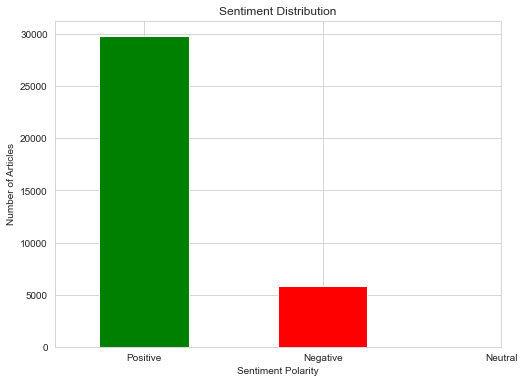

In [46]:
sentiment_counts = sentiment_df['sentiment_polarity'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of Articles')
plt.xticks([0, 1, 2], ['Positive', 'Negative', 'Neutral'], rotation=0)
plt.show()

In [50]:
df_split

Journal  \
0       Le Figaro, no. 23520      
1       Le Figaro, no. 23520      
2       Le Figaro, no. 23520      
3       Le Figaro, no. 23520      
4                   Le Monde      
...                         ...   
35667                 Le Figaro   
35668                 Le Figaro   
35669                 Le Figaro   
35670                 Le Figaro   
35671                 Le Figaro   

                                                   Titre        Date  \
0                     L'agenda cach√© de Moscou en Italie  2020-03-30   
1                     L'agenda cach√© de Moscou en Italie  2020-03-30   
2                     L'agenda cach√© de Moscou en Italie  2020-03-30   
3                     L'agenda cach√© de Moscou en Italie  2020-03-30   
4      R√©cit   Les trois semaines qui ont chamboul√© l...  2020-03-27   
...                                                  ...         ...   
35667  Pacte migratoire?: les pays du sud sauveront-i...  2020-04-12   
35668  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
35669  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
35670  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   
35671  ¬´Place de la R√©publique, les migrants n‚Äô√©taien...  2020-04-05   

                                                  Auteur  \
0                                     Lasserre, Isabelle   
1                                     Lasserre, Isabelle   
2                                     Lasserre, Isabelle   
3                                     Lasserre, Isabelle   
4      √âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret...   
...                                                  ...   
35667                                                NaN   
35668                                                NaN   
35669                                                NaN   
35670                                                NaN   
35671                                                NaN   

                                                   Texte  \
0      LES SYMBOLES comptent parfois plus que les faits.   
1                             Sur les camions militaires   
2           qui, en colonnes, ont reli√© Rome √† Bergame l   
3                            a semaine derni√®re, les sti   
4      Londres, Berlin, Rome et Bruxelles corresponda...   
...                                                  ...   
35667                                                      
35668  16/20    ¬´ Raised By Wolves ¬ª , dix √©pisodes d...   
35669                                                      
35670  20 H 55   Une exoplan√®te lointaine et d√©sol√©e ...   
35671  de squelettes g√©ants non identifiables, deux r...   

                                           extrait_debut  \
0       Sur les camions militaires qui, en colonnes, ...   
1       Sur les camions militaires qui, en colonnes, ...   
2       Sur les camions militaires qui, en colonnes, ...   
3       Sur les camions militaires qui, en colonnes, ...   
4       - Jeudi 26 mars, les Vingt-Sept devaient se r...   
...                                                  ...   
35667   2020 : la pand√©mie, gr√¢ce au plan de relance ...   
35668  0 minutes, lundi 7 decembersur warner tv, √† 20...   
35669  0 minutes, lundi 7 decembersur warner tv, √† 20...   
35670  0 minutes, lundi 7 decembersur warner tv, √† 20...   
35671  0 minutes, lundi 7 decembersur warner tv, √† 20...   

                                             extrait_fin CJournal  
0      Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
1      Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
2      Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
3      Deux semaines pour se ressaisir et s'unir ou p...   Figaro  
4      pand√©mie touche tout le monde, indiff√©remment ...    Monde  
...                                                  ...      ...  
35667  une victoire √† la Pyrrhus... Et dans tous l

In [51]:
sentiment_df

Titre  \
0      LES SYMBOLES comptent parfois plus que les faits.   
1                             Sur les camions militaires   
2           qui, en colonnes, ont reli√© Rome √† Bergame l   
3                            a semaine derni√®re, les sti   
4      Londres, Berlin, Rome et Bruxelles corresponda...   
...                                                  ...   
35666                                                      
35667  16/20    ¬´ Raised By Wolves ¬ª , dix √©pisodes d...   
35668                                                      
35669  20 H 55   Une exoplan√®te lointaine et d√©sol√©e ...   
35670  de squelettes g√©ants non identifiables, deux r...   

                                               sentiment  sentiment_polarity  
0      [{'label': 'Negative', 'score': 0.654528439044...                  -1  
1      [{'label': 'Negative', 'score': 0.579163372516...                  -1  
2      [{'label': 'Negative', 'score': 0.533666968345...                  -1  
3      [{'label': 'Negative', 'score': 0.668138563632...                  -1  
4      [{'label': 'Negative', 'score': 0.676758170127...                  -1  
...                                                  ...                 ...  
35666  [{'label': 'Negative', 'score': 0.535348117351...                  -1  
35667  [{'label': 'Negative', 'score': 0.708983063697...                  -1  
35668  [{'label': 'Negative', 'score': 0.535348117351...                  -1  
35669  [{'label': 'Negative', 'score': 0.902233958244...                  -1  
35670  [{'label': 'Negative', 'score': 0.819808423519...                  -1  

[35671 rows x 3 columns]

In [49]:
def get_sentiment_polarity(sentiment):
    label = sentiment[0]['label']
    if label == 'Positive':
        return 1
    elif label == 'Negative':
        return -1
    else:
        return 0

# Merge sentiment_df with the original DataFrame df on "Titre" column
merged_df = pd.merge(df_split, sentiment_df, on="Texte", how="inner")

# Group by newspaper names and sentiment polarity
grouped_df = merged_df.groupby(['CJournal', 'sentiment_polarity']).size().unstack(fill_value=0)

# Plot
grouped_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Positive and Negative Titles for Each Newspaper')
plt.xlabel('Newspaper')
plt.ylabel('Number of Articles')
plt.legend(['Positive', 'Negative'], loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

KeyError: 'Texte'

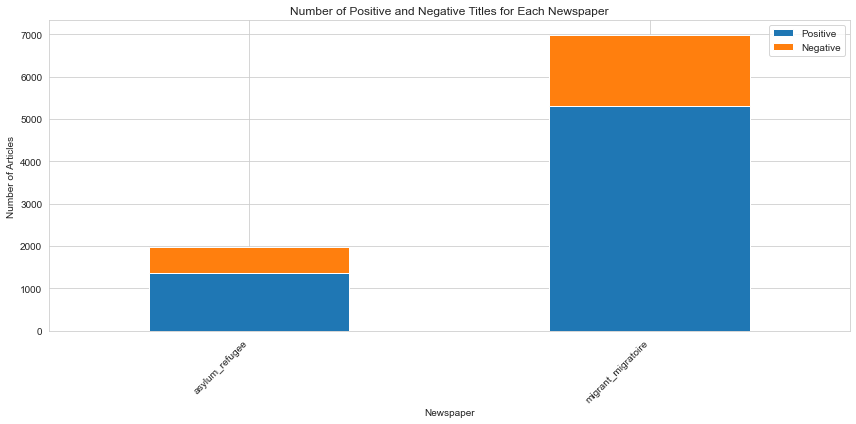

In [65]:
grouped_df_bis = merged_df.groupby(['crisis_term', 'sentiment_polarity']).size().unstack(fill_value=0)

# Plot
grouped_df_bis.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Positive and Negative Titles for Each Newspaper')
plt.xlabel('Newspaper')
plt.ylabel('Number of Articles')
plt.legend(['Positive', 'Negative'], loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [66]:
sentiment_df

Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
1     R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
...                                                                                                                                                     ...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   
8025  Quoi de neuf dans la vieille Europe ? 3√®me semaine : l'ouverture et la prosp√©rit√©.   Dossier. Les programmes de ¬´ r√©installation ¬ª de r√©fugi√©s se ...   

                                                 sentiment  sentiment_polarity  
0     [{'label': 'Negative', 'score': 0.6092225909233093}]                  -1  
1     [{'label': 'Positive', 'score': 0.5299682021141052}]                   1  
2      [{'label': 'Negative', 'score': 0.718721330165863}]                  -1  
3      [{'label': 'Negative', 'score': 0.589116096496582}]                  -1  
4     [{'label': 'Negative', 'score': 0.6685616970062256}]                  -1  
...                                                    ...                 ...  
8021  [{'label': 'Negative', 'score': 0.6489508152008057}]                  -1  
8022  [{'label': 'Negative', 'score': 0.6869106292724609}]                  -1  
8023  [{'label': 'Negative', 'score': 0.6549127697944641}]                  -1  
8024  [{'label': 'Positive', 'score': 0.5828129649162292}]                   1  
8025  [{'label': 'Positive', 'score': 0.5261464715003967}]                   1  

[8026 rows x 3 columns]

In [67]:
negatif=sentiment_df[sentiment_df["sentiment_polarity"]==-1]
negatif

Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
5                                                                    Les sept infos non li√©es au coronavirus que vous avez peut-√™tre manqu√©es cette semaine   
...                                                                                                                                                     ...   
8017                                                                                         ANALYSE   L'histoire est-elle en train de se r√©p√©ter au Liban?   
8018  La r√©ponse a minima des dirigeants europ√©ens √†¬† la trag√©die de Lampedusa  La question √©tait √†¬† l'ordre du jour du sommet des Vingt-Huit, √†¬† Bruxel...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   

                                                 sentiment  sentiment_polarity  
0     [{'label': 'Negative', 'score': 0.6092225909233093}]                  -1  
2      [{'label': 'Negative', 'score': 0.718721330165863}]                  -1  
3      [{'label': 'Negative', 'score': 0.589116096496582}]                  -1  
4     [{'label': 'Negative', 'score': 0.6685616970062256}]                  -1  
5      [{'label': 'Negative', 'score': 0.747376024723053}]                  -1  
...                                                    ...                 ...  
8017  [{'label': 'Negative', 'score': 0.8525354862213135}]                  -1  
8018  [{'label': 'Negative', 'score': 0.5824561715126038}]                  -1  
8021  [{'label': 'Negative', 'score': 0.6489508152008057}]                  -1  
8022  [{'label': 'Negative', 'score': 0.6869106292724609}]                  -1  
8023  [{'label': 'Negative', 'score': 0.6549127697944641}]                  -1  

[5883 rows x 3 columns]

In [124]:
pd.set_option('display.max_colwidth', 150)
print(negatif['Titre'].head(50))

0                                                                                                                        L'agenda cach√© de Moscou en Italie
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª
5                                                                    Les sept infos non li√©es au coronavirus que vous avez peut-√™tre manqu√©es cette semaine
6                                                                                       G√©opolitique | chronique   Nous sommes tous des migrants contrari√©s
8                                  

## Text Blob


https://github.com/Txolotl/Group4-Maya-Khaled-Diego-Sentiment-Analysis-with-CamemBERT-model/blob/main/camemBERT_Sentiment_Analysis.ipynb

#### Polarity

In [11]:
#!pip install textblob_fr

   ---------------------------------------- 561.2/561.2 kB 5.9 MB/s eta 0:00:00


In [68]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import json
import time
import torch
import datetime
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

In [69]:
AComment=[]
for comment in df['Texte'].apply(str):
    mots = []
    for word in  re.sub("\W"," ",comment ).split():
        mots.append(word)
    AComment.append(mots)


In [70]:
df['mots'] = AComment

In [71]:
df

Unnamed: 0                   Journal  \
0              1   Le Figaro, no. 23520      
1              2               Le Monde      
2              3   Le Figaro (site web)      
3              4    Le Monde (site web)      
4              5    Le Monde (site web)      
...          ...                       ...   
8021        8035             Lib√©ration      
8022        8036           Le Figaro.fr      
8023        8037    La Croix, no. 38872      
8024        8038   Lib√©ration, no. 9175      
8025        8039    La Croix, no. 38367      

                                                                                                                                                      Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
1     R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
...                                                                                                                                                     ...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   
8025  Quoi de neuf dans la vieille Europe ? 3√®me semaine : l'ouverture et la prosp√©rit√©.   Dossier. Les programmes de ¬´ r√©installation ¬ª de r√©fugi√©s se ...   

            Date  \
0     2020-03-30   
1     2020-03-27   
2     2020-03-26   
3     2020-03-26   
4     2020-03-25   
...          ...   
8021  2011-03-04   
8022  2011-03-03   
8023  2011-01-18   
8024  2010-11-11   
8025  2009-05-26   

                                                                    Auteur  \
0                                                       Lasserre, Isabelle   
1     √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                        Tandonnet, Maxime   
3      Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                               Marc Lazar   
...                                                                    ...   
8021                                                                   NaN   
8022                                                                   AFP   
8023                                                                   NaN   
8024                                                          Arnaud DUBUS   
8025                                                         GORCE Bernard   

                                                                                                                                                      Texte  \
0     LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®r

In [72]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [73]:
AllfilteredComment=[]
for comment in df['mots']:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))


df['motsFiltrer'] = AllfilteredComment

df.head(5)


Unnamed: 0                   Journal  \
0           1   Le Figaro, no. 23520      
1           2               Le Monde      
2           3   Le Figaro (site web)      
3           4    Le Monde (site web)      
4           5    Le Monde (site web)      

                                                                                                                                                   Titre  \
0                                                                                                                     L'agenda cach√© de Moscou en Italie   
1  R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                           √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                  Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                               Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   

         Date  \
0  2020-03-30   
1  2020-03-27   
2  2020-03-26   
3  2020-03-26   
4  2020-03-25   

                                                                 Auteur  \
0                                                    Lasserre, Isabelle   
1  √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                     Tandonnet, Maxime   
3   Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                            Marc Lazar   

                                                                                                                                                   Texte  \
0  LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®re, les ...   
1  Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se r√©unir en visioconf√©rence pour la troisi√®me fois en ...   
2  Fin observateur de la vie politique fran√ßaise et contributeur r√©gulier du FigaroVox, Maxime Tandonnet a notamment publi√©  Andr√© Tardieu. L'incompr...   
3  Jeudi 26¬†mars, les Vingt-Sept doivent se r√©unir en visioconf√©rence pour la troisi√®me fois en moins de trois semaines. Au programme des discussions...   
4  Tribune. L'Italie est le pays qui enregistre √†¬† la date du 25¬†mars le plus grand nombre de morts dus au coronavirus √¢¬Ä¬ì 6¬†820 √¢¬Ä¬ì et plus de 69¬†00...   

                                                                                               extrait_debut  \
0      Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®re, les stick   
1       - Jeudi 26 mars, les Vingt-Sept devaient se r√©unir en visioconf√©rence pour la troisi√®me fois en moin   
2      contributeur r√©gulier du FigaroVox, Maxime Tandonnet a notamment publi√©  Andr√© Tardieu. L'incompris     
3      n visioconf√©rence pour la troisi√®me fois en moins de trois semaines. Au programme des discussions, la   
4   date du 25¬†mars le plus grand nombre de morts dus au coronavirus √¢¬Ä¬ì 6¬†820 √¢¬Ä¬ì et plus de 69¬†000 personn   

                                                                                               extrait_fin  \
0   Deux semaines pour se ressaisir et s'unir ou pour se r√©signer √†¬† la dislocation de l'Europe, qui ne se   
1    pand√©mie touche tout le monde, indiff√©remment de la tenue de ses comptes publics, n'est pas si loin.    
2    es yeux et de se pr√©parer au changement d'un monde plut√¥t que de s'enferrer dans des obsessions qui s   
3  e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tomb√©s√¢¬Ä¬¶   

In [74]:
senti_list = []
for i in df['motsFiltrer']:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral')

df['sentiment'] = senti_list

df.head(5)

Unnamed: 0                   Journal  \
0           1   Le Figaro, no. 23520      
1           2               Le Monde      
2           3   Le Figaro (site web)      
3           4    Le Monde (site web)      
4           5    Le Monde (site web)      

                                                                                                                                                   Titre  \
0                                                                                                                     L'agenda cach√© de Moscou en Italie   
1  R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                           √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                  Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                               Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   

         Date  \
0  2020-03-30   
1  2020-03-27   
2  2020-03-26   
3  2020-03-26   
4  2020-03-25   

                                                                 Auteur  \
0                                                    Lasserre, Isabelle   
1  √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                     Tandonnet, Maxime   
3   Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                            Marc Lazar   

                                                                                                                                                   Texte  \
0  LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®re, les ...   
1  Londres, Berlin, Rome et Bruxelles correspondants - Jeudi 26 mars, les Vingt-Sept devaient se r√©unir en visioconf√©rence pour la troisi√®me fois en ...   
2  Fin observateur de la vie politique fran√ßaise et contributeur r√©gulier du FigaroVox, Maxime Tandonnet a notamment publi√©  Andr√© Tardieu. L'incompr...   
3  Jeudi 26¬†mars, les Vingt-Sept doivent se r√©unir en visioconf√©rence pour la troisi√®me fois en moins de trois semaines. Au programme des discussions...   
4  Tribune. L'Italie est le pays qui enregistre √†¬† la date du 25¬†mars le plus grand nombre de morts dus au coronavirus √¢¬Ä¬ì 6¬†820 √¢¬Ä¬ì et plus de 69¬†00...   

                                                                                               extrait_debut  \
0      Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®re, les stick   
1       - Jeudi 26 mars, les Vingt-Sept devaient se r√©unir en visioconf√©rence pour la troisi√®me fois en moin   
2      contributeur r√©gulier du FigaroVox, Maxime Tandonnet a notamment publi√©  Andr√© Tardieu. L'incompris     
3      n visioconf√©rence pour la troisi√®me fois en moins de trois semaines. Au programme des discussions, la   
4   date du 25¬†mars le plus grand nombre de morts dus au coronavirus √¢¬Ä¬ì 6¬†820 √¢¬Ä¬ì et plus de 69¬†000 personn   

                                                                                               extrait_fin  \
0   Deux semaines pour se ressaisir et s'unir ou pour se r√©signer √†¬† la dislocation de l'Europe, qui ne se   
1    pand√©mie touche tout le monde, indiff√©remment de la tenue de ses comptes publics, n'est pas si loin.    
2    es yeux et de se pr√©parer au changement d'un monde plut√¥t que de s'enferrer dans des obsessions qui s   
3  e la tenue de ses comptes publics, n'est pas si loin. Comme quoi, tous les tabous ne sont pas tomb√©s√¢¬Ä¬¶   

In [75]:
df

Unnamed: 0                   Journal  \
0              1   Le Figaro, no. 23520      
1              2               Le Monde      
2              3   Le Figaro (site web)      
3              4    Le Monde (site web)      
4              5    Le Monde (site web)      
...          ...                       ...   
8021        8035             Lib√©ration      
8022        8036           Le Figaro.fr      
8023        8037    La Croix, no. 38872      
8024        8038   Lib√©ration, no. 9175      
8025        8039    La Croix, no. 38367      

                                                                                                                                                      Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
1     R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
...                                                                                                                                                     ...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   
8025  Quoi de neuf dans la vieille Europe ? 3√®me semaine : l'ouverture et la prosp√©rit√©.   Dossier. Les programmes de ¬´ r√©installation ¬ª de r√©fugi√©s se ...   

            Date  \
0     2020-03-30   
1     2020-03-27   
2     2020-03-26   
3     2020-03-26   
4     2020-03-25   
...          ...   
8021  2011-03-04   
8022  2011-03-03   
8023  2011-01-18   
8024  2010-11-11   
8025  2009-05-26   

                                                                    Auteur  \
0                                                       Lasserre, Isabelle   
1     √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                        Tandonnet, Maxime   
3      Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                               Marc Lazar   
...                                                                    ...   
8021                                                                   NaN   
8022                                                                   AFP   
8023                                                                   NaN   
8024                                                          Arnaud DUBUS   
8025                                                         GORCE Bernard   

                                                                                                                                                      Texte  \
0     LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®r

In [76]:
fig = px.histogram(df, x="sentiment",color="sentiment", width=1000)
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2,
    bargroupgap=0.1
)
fig.show()

C:\Users\arceb\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [77]:
df[df['Unnamed: 0'] == 8038]

Unnamed: 0                   Journal  \
8024        8038   Lib√©ration, no. 9175      

                                                                                                                                                      Titre  \
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   

            Date        Auteur  \
8024  2010-11-11  Arnaud DUBUS   

                                                                                                                                                      Texte  \
8024  Ballots sur la t√™te, les bras charg√©s de sachets de nouilles ou le sac au dos, quelque 15 000 Birmans ont retravers√© mardi apr√®s-midi le fleuve Mo...   

                                                                                              extrait_debut  \
8024  de nouilles ou le sac au dos, quelque 15 000 Birmans ont retravers√© mardi apr√®s-midi le fleuve Moei,    

                                                                                                extrait_fin  \
8024  t des √©lections du week-end : la junte avait d√©cid√© de ne pas organiser de vote dans l'ensemble des d   

        CJournal     crisis_term  \
8024  Lib√©ration  asylum_refugee   

                                                                                                                                                       mots  \
8024  [Ballots, sur, la, t√™te, les, bras, charg√©s, de, sachets, de, nouilles, ou, le, sac, au, dos, quelque, 15, 000, Birmans, ont, retravers√©, mardi, a...   

                                                                                                                                                motsFiltrer  \
8024  Ballots t√™te bras charg√©s sachets nouilles sac dos 15 000 Birmans retravers√© mardi midi fleuve Moei marque fronti√®re Tha√† lande Birmanie calmement...   

     sentiment  
8024  Negative

In [78]:
selected_text = df[df['Unnamed: 0'] == 8038]['Texte'].iloc[0]
print(selected_text)

Ballots sur la t√™te, les bras charg√©s de sachets de nouilles ou le sac au dos, quelque 15 000 Birmans ont retravers√© mardi apr√®s-midi le fleuve Moei, qui marque la fronti√®re entre la Tha√†¬Ølande et la Birmanie, faisant calmement, et en sens inverse, le trajet qu'ils avaient effectu√© la veille dans la panique et la confusion.   La crisedesr√©fugi√©s de Mae Sot, du nom de la ville frontali√®re tha√†¬Ølandaise ou ces Birmans s'√©taient r√©fugi√©s lundi pour √©chapper √†¬† des affrontements entre une faction arm√©e de l'ethnie karen et l'arm√©e gouvernementale birmane, n'aura dur√© qu'un jour. Il a suffi que des leaders militaires tha√†¬Ølandais annoncent aux r√©fugi√©s, regroup√©s sur la pelouse d'un terrain de football, que la situation √©tait redevenue normale dans la ville birmane de Myawaddy, pour que les Birmans d√©cident de rentrer chez eux.  ¬´Ils ne veulent pas rester  Sur  Ce terrain de football O√†¬π ils n'ont rien √†¬† faire. Ils veulent rentrer chez eux pour surveiller 

In [79]:
selected_text = df[df['Unnamed: 0'] == 971]['Texte'].iloc[0]
print(selected_text)

La crise migratoire a confirm√© l'h√©g√©monie de Berlin sur une Union europ√©enne toujours plus divis√©e et impuissante. Ce leadership, longtemps √©conomique, est devenu politique et m√™me moral. L'√©t√© dernier, c'est Angela Merkel qui, en affirmant au nom m√™me des valeurs dont l'Europe est porteuse sa d√©termination √†¬† accueillir les r√©fugi√©s, renfor√ßa l'afflux de Syriens fuyant la guerre et les soudards du ¬´boucher de Damas¬ª. C'est elle qui, quasi solitaire, s'est activ√©e pour trouver une solution, certes tr√®s ambigu√†¬´, √†¬† une crise qui risquait de faire voler en √©clats l'espace Schengen et le projet europ√©en. Evoquant d√©but mars dans un langage familier dont elle est peu coutumi√®re  ¬´[son] foutu devoir et [son] obligation pour que l'Europe trouve un chemin ensemble¬ª, la pragmatique chanceli√®re a √©t√© le ma√†¬Ætre d'oeuvre de l'accord des Vingt-Huit avec Ankara pour fixer le flux des migrants.  ¬´Il y a aujourd'hui √†¬† nouveau une question allemande en Europe¬

In [80]:
df

Unnamed: 0                   Journal  \
0              1   Le Figaro, no. 23520      
1              2               Le Monde      
2              3   Le Figaro (site web)      
3              4    Le Monde (site web)      
4              5    Le Monde (site web)      
...          ...                       ...   
8021        8035             Lib√©ration      
8022        8036           Le Figaro.fr      
8023        8037    La Croix, no. 38872      
8024        8038   Lib√©ration, no. 9175      
8025        8039    La Croix, no. 38367      

                                                                                                                                                      Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
1     R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
...                                                                                                                                                     ...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   
8025  Quoi de neuf dans la vieille Europe ? 3√®me semaine : l'ouverture et la prosp√©rit√©.   Dossier. Les programmes de ¬´ r√©installation ¬ª de r√©fugi√©s se ...   

            Date  \
0     2020-03-30   
1     2020-03-27   
2     2020-03-26   
3     2020-03-26   
4     2020-03-25   
...          ...   
8021  2011-03-04   
8022  2011-03-03   
8023  2011-01-18   
8024  2010-11-11   
8025  2009-05-26   

                                                                    Auteur  \
0                                                       Lasserre, Isabelle   
1     √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                        Tandonnet, Maxime   
3      Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                               Marc Lazar   
...                                                                    ...   
8021                                                                   NaN   
8022                                                                   AFP   
8023                                                                   NaN   
8024                                                          Arnaud DUBUS   
8025                                                         GORCE Bernard   

                                                                                                                                                      Texte  \
0     LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®r

On peut observer que la dimension "n√©gative" n'est pas forc√©ment pertinente dans tous les cas car le registre n√©gatif peut se porter sur les

In [81]:
print(df.columns)

Index(['Unnamed: 0', 'Journal', 'Titre', 'Date', 'Auteur', 'Texte',
       'extrait_debut', 'extrait_fin', 'CJournal', 'crisis_term', 'mots',
       'motsFiltrer', 'sentiment'],
      dtype='object')


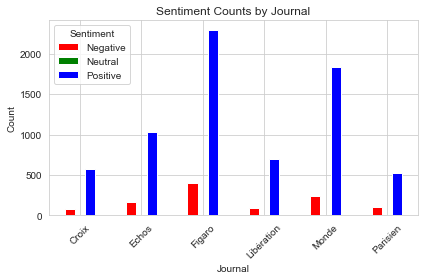

In [86]:
journal_sentiment_counts = df.groupby(['CJournal', 'sentiment']).size().unstack(fill_value=0)

# Counting sentiment occurrences for each crisis term
crisis_term_sentiment_counts = df.groupby(['crisis_term', 'sentiment']).size().unstack(fill_value=0)


# Define color palette
colors = ['red', 'green', 'blue']

# Plotting sentiment for each simplified Journal
journal_sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Counts by Journal')
plt.xlabel('Journal')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [83]:
journal_sentiment_counts

sentiment   Negative  Neutral  Positive
CJournal                               
Autre             94        1       625
Croix             83        0       574
Echos             65        0       408
Figaro           397        0      2298
Lib√©ration        92        0       691
Monde            236        1      1840
Parisien          96        0       525

M√™me si c'est tr√®s l√©ger on voit que dans l'ensemble le sentiment est plut√¥t n√©gatifs pour les journaux de droite que pour les journaux de gauche. Pour ce qui concerne le terme s√©lectionn√© pour scrapper les documents, le sentiment est plus n√©gatif pour migrant/migratoire que pour refugee/asylum.

<Figure size 720x360 with 0 Axes>

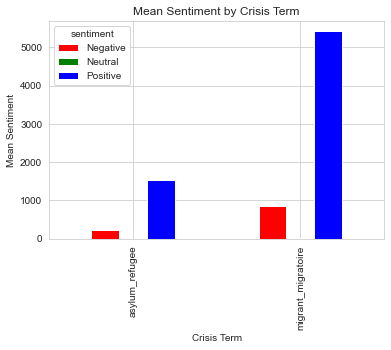

In [88]:
# Plotting sentiment for each crisis term
plt.figure(figsize=(10, 5))
# Define color palette
colors = ['red', 'green', "blue"]
crisis_term_sentiment_counts.plot(kind='bar', color=colors)
plt.title('Mean Sentiment by Crisis Term')
plt.xlabel('Crisis Term')
plt.ylabel('Mean Sentiment')
plt.show()

In [89]:
crisis_term_sentiment_counts

sentiment           Negative  Neutral  Positive
crisis_term                                    
asylum_refugee           214        0      1542
migrant_migratoire       849        2      5419

In [93]:
grouped_sentiment_counts

sentiment                      Negative  Neutral  Positive
CJournal   crisis_term                                    
Croix      asylum_refugee            15        0       132
           migrant_migratoire        68        0       442
Echos      asylum_refugee             0        0         2
           migrant_migratoire       159        1      1031
Figaro     asylum_refugee            87        0       507
           migrant_migratoire       310        0      1791
Lib√©ration asylum_refugee            22        0       209
           migrant_migratoire        70        0       482
Monde      asylum_refugee            76        0       611
           migrant_migratoire       160        1      1229
Parisien   asylum_refugee            14        0        81
           migrant_migratoire        82        0       444

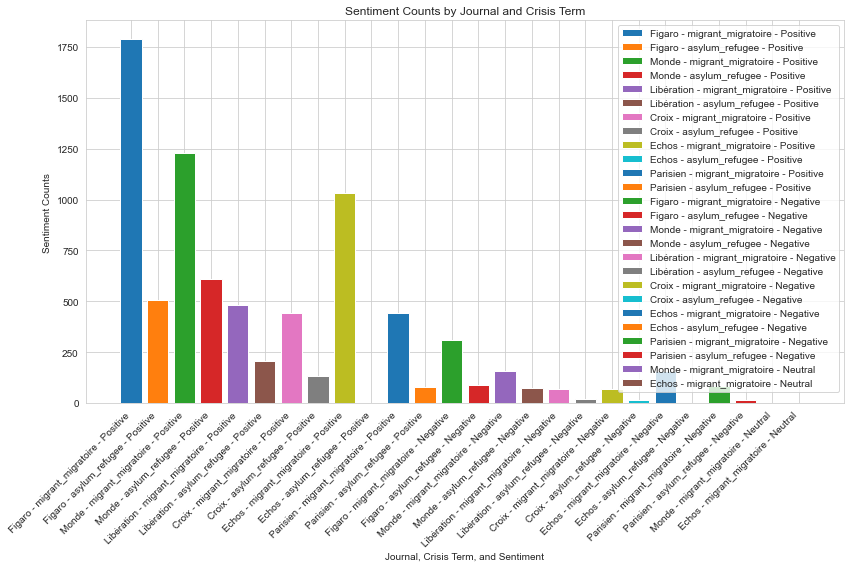

In [102]:
grouped_sentiment_counts = df.groupby(['CJournal', 'crisis_term', 'sentiment']).size().unstack(fill_value=0)

# Plotting sentiment for each Simplified Journal and crisis term
plt.figure(figsize=(12, 8))

# Iterate over each sentiment category
for sentiment in df['sentiment'].unique():
    # Subset the DataFrame for the specific sentiment
    df_sentiment = df[df['sentiment'] == sentiment]
    # Group by 'CJournal', 'crisis_term', and calculate sentiment counts
    grouped_sentiment_counts = df_sentiment.groupby(['CJournal', 'crisis_term']).size().unstack(fill_value=0)

    # Iterate over unique newspapers and crisis terms
    for journal in df['CJournal'].unique():
        for crisis_term in df['crisis_term'].unique():
            try:
                # Get sentiment count for the specific combination
                sentiment_count = grouped_sentiment_counts.loc[journal, crisis_term]
                # Plotting the sentiment count
                plt.bar(f"{journal} - {crisis_term} - {sentiment}", sentiment_count, label=f"{journal} - {crisis_term} - {sentiment}")
            except KeyError:
                pass

plt.title('Sentiment Counts by Journal and Crisis Term')
plt.xlabel('Journal, Crisis Term, and Sentiment')
plt.ylabel('Sentiment Counts')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


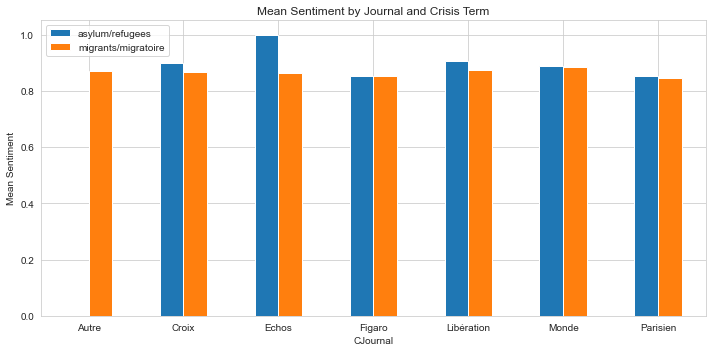

In [63]:
# Adding a 'Key' column to indicate the categories (here, 'Pauvres' and 'Autres')
df['Key'] = df['crisis_term'].apply(lambda x: 'migrants/migratoire' if x == 'migrant_migratoire' else 'asylum/refugees')

# Grouping by 'Simplified_Journal' and 'Key' and calculating mean sentiment
grouped_sentiment = df.groupby(['CJournal', 'Key'])['sentiment'].mean().unstack()

# Plotting sentiment for each Simplified Journal and Key
ax = grouped_sentiment.plot(kind='bar', ylabel='Mean Sentiment', title='Mean Sentiment by Journal and Crisis Term', figsize=(10, 5), rot=0)
plt.legend(['asylum/refugees', 'migrants/migratoire'], loc='upper left')
plt.tight_layout()
plt.show()

In [103]:
df['sentiment'] = df['sentiment'].replace('Positive',1)
df['sentiment'] = df['sentiment'].replace('Neutral',2)
df['sentiment'] = df['sentiment'].replace('Negative',0)

C:\Users\arceb\AppData\Local\Temp\ipykernel_2988\3213211793.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [104]:
df.drop( df[ df['sentiment'] == 2 ].index, inplace=True)

#### Subjectivity

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [120]:
subjectivities = []

for text in df['motsFiltrer']:
    blob = tb(text)
    subjectivity = blob.subjectivity
    subjectivities.append(subjectivity)

# Add subjectivities to DataFrame
df['subjectivity'] = subjectivities

In [121]:
df

Unnamed: 0                   Journal  \
0              1   Le Figaro, no. 23520      
1              2               Le Monde      
2              3   Le Figaro (site web)      
3              4    Le Monde (site web)      
4              5    Le Monde (site web)      
...          ...                       ...   
8021        8035             Lib√©ration      
8022        8036           Le Figaro.fr      
8023        8037    La Croix, no. 38872      
8024        8038   Lib√©ration, no. 9175      
8025        8039    La Croix, no. 38367      

                                                                                                                                                      Titre  \
0                                                                                                                        L'agenda cach√© de Moscou en Italie   
1     R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r...   
2                                              √†¬âlargissement de l'Union europ√©enne √†¬† l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª   
3                                                                     Coronavirus¬†: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne   
4                                                  Marc Lazar¬†: ¬´¬†Plus l'Italie fait nation face √†¬† l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne¬†¬ª   
...                                                                                                                                                     ...   
8021                                                                                                                        TUNISIE √©vacuation des r√©fugi√©s   
8022                                                                                                                Libye/UE: 30M d'euros pour les r√©fugi√©s   
8023                                                                                                                                               Courrier   
8024  Reportage   L'√©trange aller-retour des Karens opprim√©s par la junte birmane  Apr√®s un bref exil en Tha√†¬Ølande, les r√©fugi√©s ayant fui les combats ...   
8025  Quoi de neuf dans la vieille Europe ? 3√®me semaine : l'ouverture et la prosp√©rit√©.   Dossier. Les programmes de ¬´ r√©installation ¬ª de r√©fugi√©s se ...   

            Date  \
0     2020-03-30   
1     2020-03-27   
2     2020-03-26   
3     2020-03-26   
4     2020-03-25   
...          ...   
8021  2011-03-04   
8022  2011-03-03   
8023  2011-01-18   
8024  2010-11-11   
8025  2009-05-26   

                                                                    Auteur  \
0                                                       Lasserre, Isabelle   
1     √†¬âric Albert, C√©cile Boutelet, J√©r√¥me Gautheret et Virginie Malingre   
2                                                        Tandonnet, Maxime   
3      Eric Albert, J√©r√¥me Gautheret, C√©cile Boutelet et Virginie Malingre   
4                                                               Marc Lazar   
...                                                                    ...   
8021                                                                   NaN   
8022                                                                   AFP   
8023                                                                   NaN   
8024                                                          Arnaud DUBUS   
8025                                                         GORCE Bernard   

                                                                                                                                                      Texte  \
0     LES SYMBOLES comptent parfois plus que les faits. Sur les camions militaires qui, en colonnes, ont reli√© Rome √†¬† Bergame la semaine derni√®r

In [122]:
selected_text = df[df['Unnamed: 0'] == 15]['Texte'].iloc[0]
print(selected_text)

Le pr√©sident turc Recep Tayyip Erdogan a demand√© √†¬† l'Otan son ¬´ soutien concret ¬ª dans le conflit en Syrie, lors d'une visite √†¬† Bruxelles lundi.   ¬ª LIRE AUSSI - Afflux explosif de migrants √†¬† la fronti√®re gr√©co-turque     ¬´ Nous attendons un soutien concret de la part de tous nos alli√©s ¬ª, a lanc√© le dirigeant apr√®s une rencontre avec le secr√©taire g√©n√©ral de l'Otan Jens Stoltenberg. ¬´ L'Otan est dans un processus critique dans lequel elle doit clairement montrer sa solidarit√© d'alliance ¬ª avec la Turquie, a ajout√© M. Erdogan.  Ankara souhaite que l'Otan applique pleinement ses d√©cisions prises entre 2012 et 2015 de soutenir la d√©fense a√©rienne turque, a-t-il expliqu√©. La visite de M. Erdogan dans la capitale de l'UE intervient apr√®s sa d√©cision d'ouvrir les fronti√®res turques au passage des migrants et des r√©fugi√©s qui se trouvent sur son territoire, pour forcer les pays europ√©ens √†¬† ¬´ apporter leur soutien aux solutions politiques et humanitai

In [123]:
selected_text = df[df['Unnamed: 0'] == 19]['Texte'].iloc[0]
print(selected_text)

Face aux conditions de vie pr√©caires des migrants dans les √†¬Æles grecques, l'Allemagne prend la t√™te d'une coalition de pays europ√©ens ¬´?volontaires?¬ª √†¬† l'accueil de mineurs.   Une coalition de pays ¬´ volontaires ¬ª de l'Union europ√©enne envisage de prendre en charge jusqu'√†¬† 1 500 enfants migrants actuellement bloqu√©s sur les √†¬Æles grecques, par mesure de soutien ¬´ humanitaire ¬ª, a annonc√© lundi 9 mars le gouvernement allemand.  ? REPORTAGE. √© Paris, offrir un peu de r√©pit aux jeunes migrants isol√©s   ¬´ Nous voulons aider la Gr√®ce √†¬† faire face √†¬† la situation humanitaire difficile de 1 000 √†¬† 1 500 enfants se trouvant sur les √†¬Æles ¬ª du pays, ont ajout√© les partis de la coalition gouvernementale de la chanceli√®re Angela Merkel, conservateurs et sociaux-d√©mocrates, √†¬† l'issue d'une r√©union de plusieurs heures qui avait commenc√© dimanche soir. ¬´ Il s'agit d'enfants qui, en raison d'une maladie ont urgemment besoin de soins, ou d'enfants non acc

#### Learning

In [105]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 1
device = torch.device('cuda')

In [106]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [107]:
# Creates list of texts and labels
text = df['Texte'].to_list()
labels = df['sentiment'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,truncation=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [108]:
tokenizer.encode?

In [109]:
input_ids

array([[    5,  5311, 23196, ..., 23808,     9,     6],
       [    5,  3289,     7, ...,  6401,    14,     6],
       [    5,  4498,    21, ..., 27906,  6599,     6],
       ...,
       [    5,  6899,    25, ...,    56,    15,     6],
       [    5, 11366,  7043, ..., 21124,  6841,     6],
       [    5,   795,   193, ...,    16,   454,     6]])

In [110]:

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [111]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
type(model)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))




    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

print("Model saved!")
torch.save(model.state_dict(), "/content/drive/MyDrive/truspilot_category_data/sentiments_pytorch.pt")

### FLAUBERT

In [113]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

loaded_tokenizer = AutoTokenizer.from_pretrained('flaubert/flaubert_large_cased')
loaded_model = AutoModelForSequenceClassification.from_pretrained("DemangeJeremy/4-sentiments-with-flaubert")

nlp = pipeline('sentiment-analysis', model=loaded_model, tokenizer=loaded_tokenizer)

pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

C:\Users\arceb\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arceb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



In [115]:
# Creating an empty list to store the results
articles_sentiment = []

# Iterating over each row in the DataFrame
for index, row in df.iterrows():
    try:
        content = row['Titre']
        sentiment = nlp(content)
        articles_sentiment.append({'article': content, 'sentiment': sentiment})
    except Exception as e:
        print(f"Error processing article at index {index}: {e}")

KeyboardInterrupt: 

In [116]:
articles_sentiment

[{'article': "L'agenda cach√© de Moscou en Italie",
  'sentiment': [{'label': 'POSITIVE', 'score': 0.6883031129837036}]},
 {'article': "R√©cit   Les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne  Un sommet devait se tenir, jeudi 26 mars, pour faire avancer la r√©forme de la zone euro, dont la solidit√© est mise √†\xa0 mal par la pand√©mie",
  'sentiment': [{'label': 'MIXED', 'score': 0.4768875241279602}]},
 {'article': "√†\x89largissement de l'Union europ√©enne √†\xa0 l'heure du Coronavirus: ¬´une fuite en avant suicidaire dans le d√©ni¬ª",
  'sentiment': [{'label': 'MIXED', 'score': 0.40838807821273804}]},
 {'article': "Coronavirus\xa0: les trois semaines qui ont chamboul√© l'orthodoxie √©conomique europ√©enne",
  'sentiment': [{'label': 'OBJECTIVE', 'score': 0.4552094638347626}]},
 {'article': "Marc Lazar\xa0: ¬´\xa0Plus l'Italie fait nation face √†\xa0 l'√©pid√©mie, plus elle s'√©loigne de l'Union europ√©enne\xa0¬ª",
  'sentiment': [{'label': 'OBJECTIVE', 's